# Alli Khadga Jyoth - 19024 DSE

In [1]:
from gym import Env
import gym
from gym.spaces import Discrete, Box, Dict
import numpy as np
import random
import matplotlib.pyplot as plt

> The environment is slightly different from the one submitted in Assignment2. Because of some debugging issues caused when applying the learning models

In [2]:
class WarehouseAgent:
    def __init__(self):
        self.GRID_DIM = [7, 6]

        self.agent_position = [1, 2]

        self.box_location = [4, 3]
        self.goal_location = [3, 1]
        self._action_to_direction = {
            0: np.array([-1, 0]),
            1: np.array([1, 0]),
            2: np.array([0, -1]),
            3: np.array([0, 1]),
        }
        self._ACTIONLOOKUP = {
            0: "move up",
            1: "move down",
            2: "move left",
            3: "move right",
            4: "push",
        }
        self.GRID_DIM = np.asarray(self.GRID_DIM)
        self.GRID = np.zeros(
            self.GRID_DIM
        )  # The Boundaries are the walls, so playing space is only [:-2,:-2]
        self.GRID[:, [0, -1]] = 1
        self.GRID[[0, -1], :] = 1
        self.GRID[[1, 2, 5], 3:5] = 1
        self.walls = 1
        self.action_space = Discrete(len(self._ACTIONLOOKUP.keys()))
        self.state_space = Discrete(self.GRID_DIM[0] * self.GRID_DIM[1])
        self.observation_space = Dict(
            {
                "agent": Box(
                    np.array([0, 0]),
                    np.array([self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1]),
                    shape=(2,),
                    dtype=int,
                ),
                "box": Box(
                    np.array([0, 0]),
                    np.array([self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1]),
                    shape=(2,),
                    dtype=int,
                ),
                "target": Box(
                    np.array([0, 0]),
                    np.array([self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1]),
                    shape=(2,),
                    dtype=int,
                ),
            }
        )
        self._agent_location = np.array(self.agent_position)
        self._box_location = np.array(self.box_location)
        self._target_location = np.array(self.goal_location)

    #         print(self.GRID)

    def step(self, action):
        self._prev_agent_location = None
        self._prev_box_location = None
        moved_box = False

        if action < 4:
            moved_player = self._move(action)
        else:
            moved_player, moved_box = self._push(action)

        done, reward = self.is_over()
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, done, info

    def render(self):
        rend = self.GRID.copy().astype(dtype="U1")
        rend[self._agent_location[0], self._agent_location[1]] = "A"
        rend[self._box_location[0], self._box_location[1]] = "B"
        rend[self._target_location[0], self._target_location[1]] = "T"
        if np.array_equal(self._target_location, self._box_location):
            rend[self._target_location[0], self._target_location[1]] = "D"
        return print(rend)

    def reset(self, seed=None, return_info=False, options=None):
        self._agent_location = np.array(self.agent_position)
        self._box_location = np.array(self.box_location)
        self._target_location = np.array(self.goal_location)

        observation = self._get_obs()
        info = self._get_info()
        return (observation, info) if return_info else observation

    def _get_obs(self):
        return {
            "agent": self._agent_location,
            "box": self._box_location,
            "target": self._target_location,
        }

    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._box_location - self._target_location, ord=1
            )
        }

    def _state_in_seq(self):
        m, n = self._agent_location
        seq = m * self.GRID.shape[1] + n
        return seq

    def _push(self, action):
        loc = self._box_location - self._agent_location
        #         print(f'loc{loc}, box :{self._box_location}, agent:{self._agent_location}')
        push_dir = None
        for idx, val in enumerate(self._action_to_direction.values()):
            if np.array_equal(loc, val):
                valid = True
                push_dir = idx
                break
            else:
                valid = False

        if valid:
            self._prev_agent_location = self._agent_location
            self._prev_box_location = self._box_location
            self._box_location = (
                self._box_location + self._action_to_direction[push_dir]
            )
            if self.GRID[self._box_location[0], self._box_location[1]] == 1:
                self._box_location = self._prev_box_location
                return False, False
            else:
                self._agent_location = (
                    self._agent_location + self._action_to_direction[push_dir]
                )
                return True, True

        return False, False

    def _move(self, action):
        self._prev_agent_location = self._agent_location
        self._prev_box_location = self._box_location
        self._agent_location = self._agent_location + self._action_to_direction[action]
        #             print(self.GRID[self._agent_location],self._agent_location,self.GRID)
        if self.GRID[self._agent_location[0], self._agent_location[1]] == 1:
            self._agent_location = self._prev_agent_location
            return False
        elif np.array_equal(self._agent_location, self._box_location):
            self._agent_location = self._prev_agent_location
            return False
        return True

    def is_over(self):
        if np.array_equal(self._box_location, self._target_location):  # checking if the box is at the target already
            done = True
            reward = 0
        elif (sum(a := np.array([True if self.GRID[(self._box_location + val)[0], (self._box_location + val)[1]]== 1 
                                 else False for val in self._action_to_direction.values()]))>= 1):
            # basically checking if there are atleast 1 wall adjacent to box
            if sum(a) > 1:
                done = True
                reward = -100 ## Reward for getting stuck at wall reward -1 not a good option ####
            elif sum(a) == 1:
                if ~(self._box_location - self._target_location).all():
                    done = False
                    reward = -1
                    return done, reward
                else:
                    #                 print(a)
                    direc = np.where(a == True)
                    #                 print(direc)
                    direc = direc[0][0]
                    left = self._box_location + self._action_to_direction[direc]
                    right = left.copy()
                    if direc in [0, 1]:
                        count = 0
                        while (self.GRID[left[0], left[1]] != 0) and (
                            self.GRID[right[0], right[1]] != 0
                        ):

                            left = np.clip(
                                left + self._action_to_direction[2],
                                [0, 0],
                                [self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1],
                            )
                            right = np.clip(
                                right + self._action_to_direction[3],
                                [0, 0],
                                [self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1],
                            )
                            count += 1
                            if count >= self.GRID_DIM[1]:
                                done = True
                                reward = -100 #box getting stuck
                                return done, reward
                                break
                    else:
                        count = 0
                        while (self.GRID[left[0], left[1]] != 0) and (
                            self.GRID[right[0], right[1]] != 0
                        ):
                            left = np.clip(
                                left + self._action_to_direction[1],
                                [0, 0],
                                [self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1],
                            )
                            right = np.clip(
                                right + self._action_to_direction[0],
                                [0, 0],
                                [self.GRID_DIM[0] - 1, self.GRID_DIM[1] - 1],
                            )
                            count += 1
                            if count >= self.GRID_DIM[0]:
                                done = True
                                reward = -100 #getting stuck
                                return done, reward
                                break

                    done = False
                    reward = -1
                    return done, reward
         # gotta check if the box is not adjacent to 2 walls but still is terminating state like the boundary walls
        else:
            done = False
            reward = -1
        return done, reward

## On-Policy Monte Carlo
> First visit on-policy MC($\epsilon$- soft)

In [33]:
env = WarehouseAgent()
#Defining the hyper parameters
gamma = 0.9
epsilon = 0.1
total_episodes = 10

#Initializing the Q-table with 0
Q = np.zeros((env.state_space.n,env.action_space.n))  # (total no. of states * total no. of actions)
policy = (Q.copy()+1)/env.action_space.n
Q.shape

(42, 5)

In [34]:
# creating Returns list, where each state has five possible actions to take
Returns = {}
for state in [str(s) for s in range(0,env.state_space.n)]:
    for action in [str(a) for a in range(0,env.action_space.n)]:
        Returns[state+", "+action] = []

In [35]:
timestep_reward=[]
for ep in range(total_episodes):
    G = 0
    t = 0
    env.reset()
    current_state = env._state_in_seq()  # state
    total_reward = 0 
    trajectory = []
    done = False
    while not done:
        t+=1
#         print(t)
        current_action = np.random.choice(range(0,env.action_space.n),p=policy[current_state]) 
        
        observation, reward, done, info = env.step(current_action)   # Take one step in the environment
        next_state = env._state_in_seq()

        trajectory.append((current_state, current_action, reward))
        total_reward+= reward
        current_state = next_state
        if done:
            break

    timestep_reward.append(total_reward)
    print('Episode:',ep+1)
    for idx, step in enumerate(trajectory[::-1]):
        G = gamma*G + step[2]
        
        # first visit check
        if [step[0],step[1]] not in np.array(np.array(trajectory[::-1])[:,0:2][idx+1:]).tolist():
            Returns[str(step[0])+", "+str(step[1])].append(G)
            Q[step[0]][step[1]] = np.mean(Returns[str(step[0])+", "+str(step[1])])
            astar = np.argmax(Q[step[0]])
            for at in range(env.action_space.n):
                if at == astar:
                    policy[step[0]][at] = 1-epsilon+(epsilon/(env.action_space.n))
                else:
                    policy[step[0]][at] = epsilon/(env.action_space.n)

Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10


[['1' '1' '1' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'T' '0' '0' '0' '1']
 ['1' '0' '0' 'A' 'B' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]


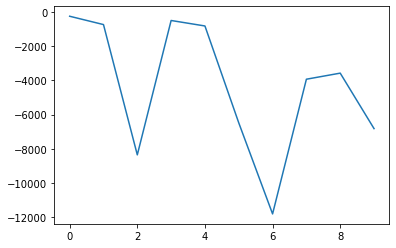

In [36]:
env.render()
plt.plot(timestep_reward)

## Off-Policy MC

In [84]:
env = WarehouseAgent()
#Defining the hyper parameters
gamma = 0.9
epsilon = 0.1
max_episodes = 100

#Initializing the Q-table with 0
Q = np.zeros((env.state_space.n,env.action_space.n))  # (total no. of states * total no. of actions)
policy = np.argmax(Q,axis=1)
C = np.zeros((env.state_space.n,env.action_space.n))

In [85]:
for ep in range(max_episodes):
    env.reset()
    current_state = env._state_in_seq()  # state
    
    G = 0
    W = 1
    
    trajectory = []
    done = False
    while not done:
        action_by_b_policy = np.random.randint(env.action_space.n)
        
        observation, reward, done, info = env.step(action_by_b_policy)   # Take one step in the environment
        next_state = env._state_in_seq()

        trajectory.append((current_state, action_by_b_policy, reward))
        current_state = next_state
#     print('Episode:',ep+1)
    for idx, step in enumerate(trajectory[::-1]):
        G = gamma*G + step[2]
#         print(C,step)
        C[step[0],step[1]] += W
        Q[step[0],step[1]] += (W/C[step[0],step[1]]) * (G-Q[step[0],step[1]])
        policy[step[0]] = np.argmax(Q[step[0]])
        
        if step[1] != policy[step[0]]:
            break
                    
        W = W*(1/(1/env.action_space.n))
# print(C)

#### Evaluating the policy

In [86]:
env = WarehouseAgent()
env.reset()
# print(env._state_in_seq())
done = False
total_reward = 0
max_steps = 10000
step=0
while not done and step<max_steps:
    state = env._state_in_seq()
    act = policy[state]
    obs,reward,done,info = env.step(act)
    total_reward+=reward
    step+=1
env.render()
print('Total reward got in the run',total_reward)

[['1' '1' '1' '1' '1' '1']
 ['1' '0' 'A' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'T' '0' '0' '0' '1']
 ['1' '0' '0' 'B' '0' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]
Total reward got in the run -10000


## SARSA

In [26]:
def ep_greedy(env,Q,epsilon=0.9):
    seq = env._state_in_seq()
    if np.random.random()<epsilon:
        x=(Q[seq,:]!=0).all()
        if x :           
            action = np.argmax(Q[seq,:])
        else:
            action = np.where(Q[seq,:]==0)[0]
            action=action[0]
    else:
        action = np.random.randint(env.action_space.n)
    return action
def Sarsa(env,alpha, gamma, epsilon, episodes, max_steps):
    timestep_reward = []
    for ep in range(episodes):
        env.reset()
        done = False
        total_reward = 0        
        curr_state = env._state_in_seq()
        curr_a = ep_greedy(env,Q)
        t = 0
        while not done :
            obs, reward, done, info = env.step(curr_a)
            next_state = env._state_in_seq()
            total_reward+= reward
            next_act = ep_greedy(env,Q)
            t+=1

            Q[curr_state, curr_a] += alpha * ( reward + (gamma * Q[next_state, next_act] ) - Q[curr_state, curr_a] )
            curr_state = next_state
            curr_a = next_act

#         print(t)
        timestep_reward.append(total_reward)
    return timestep_reward

In [27]:
env = WarehouseAgent()
n_states, n_actions = env.state_space.n, env.action_space.n
Q = np.zeros((n_states, n_actions))

alpha = 0.2
gamma = 0.9
epsilon = 0.9
episodes = 200
timestep_reward = Sarsa(env,alpha, gamma, epsilon, episodes, max_steps)
# print(timestep_reward)

[['1' '1' '1' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'D' '0' '0' '0' '1']
 ['1' 'A' '0' '0' '0' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]


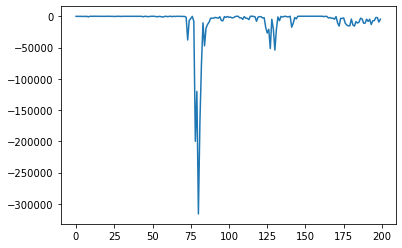

In [28]:
env.render()
plt.plot(timestep_reward)

## Q-Learning

In [29]:
def ep_greedy(env,Q,action_count,epsilon=0.9):
    seq = env._state_in_seq()
    if np.random.random()<epsilon:
        x=(Q[seq,:]!=0).all()
        if x :           
            action = np.argmax(Q[seq,:])
        else:
            action = np.where(action_count[seq]==0)[0]
            action=action[0]
    else:
        action = np.random.randint(env.action_space.n)
    return action
def QL(env,alpha, gamma, epsilon, episodes):
    timestep_reward = []
    for ep in range(episodes):
        env.reset()
        done = False
        total_reward = 0        
        curr_state = env._state_in_seq()
        t = 0
        while not done :
            curr_state = env._state_in_seq()
            curr_a = ep_greedy(env,Q,action_count)
            action_count[curr_state,curr_a]+=1
            obs, reward, done, info = env.step(curr_a)
            next_state = env._state_in_seq()
            total_reward+= reward
            t+=1
            Q[curr_state, curr_a] += alpha * ( reward + (gamma * np.max(Q[next_state]) ) - Q[curr_state, curr_a] )
            curr_state = next_state
#         print(t)
        timestep_reward.append(total_reward)
    return timestep_reward

In [30]:
env = WarehouseAgent()
env.render()
n_states, n_actions = env.state_space.n, env.action_space.n
Q = np.zeros((n_states, n_actions))
action_count = np.zeros((env.state_space.n, env.action_space.n))

alpha = 0.01
gamma = 0.9
epsilon = 0.9
episodes = 500

timestep_reward = QL(env,alpha, gamma, epsilon, episodes)
# print(timestep_reward)

[['1' '1' '1' '1' '1' '1']
 ['1' '0' 'A' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'T' '0' '0' '0' '1']
 ['1' '0' '0' 'B' '0' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]


[['1' '1' '1' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' '0' '0' '1' '1' '1']
 ['1' 'T' '0' '0' '0' '1']
 ['1' 'A' '0' '0' '0' '1']
 ['1' 'B' '0' '1' '1' '1']
 ['1' '1' '1' '1' '1' '1']]


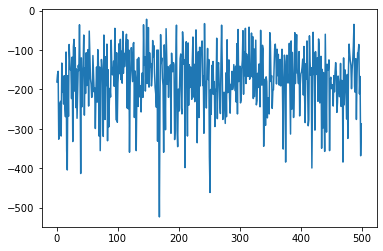

In [31]:
env.render()
plt.plot(timestep_reward)

## Q2

**On-Policy MC:** 
> Here the target policy is the same as the one being used to generate the episode. Since it's a MC learning the number of episodes required to converge to an optimal policy is large and the policy update takes large time

**Off-Policy MC:**
> Here the target policy is different from the one being used to generate the episode. The Convergence is atleast as fast as on-policy MC if not faster.

**SARSA:**
> It is a td(0) learning model, which learns from each state-action-reward-state-action pair. Its the fastest and the most efficient learning model out the ones used, It might take large number of episodes to converge, but that is offset by its fast computation time.

**Q-Learning:**
> It tries to take the best state-action pair which maximizes the action-value of next state. But the model is doesn;t converge to a maximum easily and fluctuates around it. 